# Stock Market Technical Analysis & Machine Learning Models

### Libraries Imports

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import talib as ta
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
from database import engine

### Technical Analysis

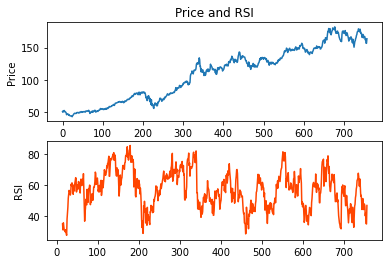

None


In [22]:
   query_1 = """
select
	"Date" as "Date",
	"AAPL" as "Close"
from
	close_price cp
    """
    
    
def ADX (ticker):
    stock_data = pd.read_sql_query(query_1, engine)
    # Calculate ADX
    stock_data['ADX'] = ta.ADX(stock_data['High'], stock_data['Low'], stock_data['Close'])
    #Create subplots
    fig, (ax1, ax2) = plt.subplots(2)
    # Plot ADX with the price
    ax1.set_ylabel('Price')
    ax1.plot(stock_data['Close'])
    ax2.set_ylabel('ADX')
    ax2.plot(stock_data['ADX'], color='red')
    ax1.set_title('Price and ADX')
    plt.show()
    return

def RSI (ticker):
    
    stock_data = pd.read_sql_query(query_1, engine)
    stock_data['RSI'] = ta.RSI(stock_data['Close'])
    
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_ylabel('Price')
    ax1.plot(stock_data['Close'])
    ax2.set_ylabel('RSI')
    ax2.plot(stock_data['RSI'], color='orangered')
    ax1.set_title('Price and RSI')
    plt.show()
    
    return
             
print(RSI("AAPL"))

### ML Classification Model for Stock Market Prediction

In [ ]:
def add_features(df):
    ''' This function takes the stock dataframe, adds to it new columns of different technical indicators as predictive variables for the model to use. '''
      
    n=7
    df['RSI'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)
    df['MA'] = df['Close'].shift(1).rolling(window=n).mean()
    df['Corr'] = df['Close'].shift(1).rolling(window=n).corr(df['MA'].shift(1))
    df['SAR'] = ta.SAR(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), 0.2, 0.2)
    df['ADX'] = ta.ADX(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), np.array(df['Open']), timeperiod=n)
    df['Prev_High'] = df['High'].shift(1)
    df['Prev_Low'] = df['Low'].shift(1)
    df['Prev_Close'] = df['Close'].shift(1)
    df['Open_change'] = df['Open'] - df['Open'].shift(1)
    df['Open_close_change'] = df['Open'] - df['Prev_Close']
    df['Return'] = (df['Open'].shift(-1) - df['Open']) / df['Open']
    df['return_lag1'] = df['Return'].shift(1)
    df['return_lag2'] = df['Return'].shift(2)
    df['return_lag3'] = df['Return'].shift(3)
    df = df.dropna()
    
    return df 

In [17]:
def add_signals(df):
    ''' This function takes a dataframe and adds a new column for signals, the signals are based on the distribution of the observed returns of the stock during the
        selected period, a 'Sell' signal will be assigned for all observed returns that lie below the 40th quantile (negative returns) to signal a predicted loss, 
        similarly a 'Buy' signal will be assigned for all observed returns that lie above the 60th quantile (positive returns) to signal a predicted gain, and 
        a 'Hold' signal otherwise, mostly small percentage changes in returns. '''
    
    df['Signal'] = 'Hold'
    df.loc[df['Return'] > df['Return'].quantile(q=0.60), 'Signal'] = 'Buy'
    df.loc[df['Return'] < df['Return'].quantile(q=0.40), 'Signal'] = 'Sell'
    
    return df

In [ ]:
def get_training_split(df):
    ''' This function takes a dataframe and returns one dataframe and one pandas series, the returned dataframe conatins the features of the training dataset,
        and the returned series contain the related signals of the training dataset. '''
    
    split = int(len(df)*0.8)
    
    features = df.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'Return'], axis=1)
    signals = df['Signal']
    
    training_features_df = features[:split]
    training_signals_series = signals[:split]
    
    return training_features_df, training_signals_series;

In [ ]:
def get_testing_split(df):
    ''' This function takes a dataframe and returns one dataframe and one pandas series, the returned dataframe conatins the features of the testing dataset,
         and the returned series contains the related signals of the testing dataset. '''
    
    split = int(len(df)*0.8)
    
    features = df.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'Return'], axis=1)
    signals = df['Signal']
    
    testing_features_df = features[split:]
    testing_signals_series = signals[split:]
    
    return testing_features_df, testing_signals_series;

In [ ]:
def prediction_model(trainF, trainS, testF):
    ''' This function takes two dataframes and one pandas series. We will pass the training features dataframe, training actual signals series, 
        and the testing features dataframe that we want the model to predict. The function returns a pandas series of the predicted signals. '''
    
    c = [10,100,1000,10000]
    g = [1e-2, 1e-1, 1e0]
    parameters = {'svc__C' : c,
                  'svc__gamma': g,
                  'svc__kernel': ['rbf']
                 }
    steps = [('scaler', StandardScaler()), ('svc', SVC())]
    pipeline = Pipeline(steps)
    
    rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))
    rcv.fit(trainF, trainS)
    best_C = rcv.best_params_['svc__C']
    best_kernel = rcv.best_params_['svc__kernel']
    best_gamma = rcv.best_params_['svc__gamma']
    
    cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)
    ss = StandardScaler()
    
    cls.fit(ss.fit_transform(trainF), trainS)
    predicted_signals = cls.predict(ss.transform(testF))
    
    return predicted_signals

In [ ]:
def plot_confusion_matrix(array):
    ''' This function takes an array (confusion matrix) and returns a plot to visualise the performance. '''
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax = plt.subplot()
    sns.heatmap(array, annot=True, ax=ax)

    ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
    ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
    
    return plt.show()

In [ ]:
def classification_model_evaluation(df):
    ''' This function takes the stock's dataframe, mutates it in the desired format, splits the dataset into a training and testing datasets, gets the model predictions
         and evaluates it, and then returns the confusion matrix plot and the classification accuracy report (out-of-sample accuracy is based on the testing dataset). '''
    
    df1 = add_features(df)
    df2 = add_signals(df1)
    
    trainF, trainS = get_training_split(df2)
    testF, testS = get_testing_split(df2)
    
    predicted_signals = prediction_model(trainF, trainS, testF)
    
    confusion_matrix_ = confusion_matrix(testS, predicted_signals)
    confusion_matrix_plot = plot_confusion_matrix(confusion_matrix_)
    out_of_sample_accuracy = classification_report(testS, predicted_signals)
    
    return print(confusion_matrix_plot, out_of_sample_accuracy)

### Stock Market Prediction Using Prophet Package